## Project code 

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sidetable as std 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
from itertools import combinations 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [99]:
pip install sidetable

Note: you may need to restart the kernel to use updated packages.


Loading the dataset 

In [100]:
data = pd.read_csv(r"C:\Users\Asus\Desktop\Herst doc\Final project\data_banknote_authentication.txt", header=None)
data.columns = ['variance', 'skewness', 'kurtosis', 'entropy', 'class']
data.head()

,variance,skewness,kurtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


Exploratory Data Analysis

Total number of records: 1372
Total number of fake notes: 610
Total number of real notes: 762

There are no missing values in the dataset


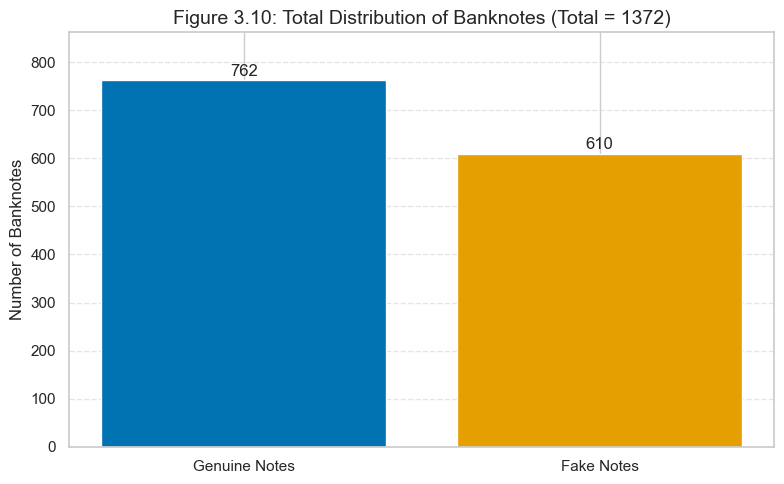

In [101]:

# Count total records, fake notes, and genuine notes
n_records = len(data)
n_fake_notes = len(data[data['class'] == 1])  # 1 = Fake notes
n_real_notes = len(data[data['class'] == 0])  # 0= Genuine notes

# Display results
print("Total number of records: {}".format(n_records))
print("Total number of fake notes: {}".format(n_fake_notes))
print("Total number of real notes: {}".format(n_real_notes))

# Check for missing values
missing_values = data.isnull().sum().sum()
if missing_values == 0:
    print("\nThere are no missing values in the dataset")
else:
    print("\nThe dataset has {} missing values".format(missing_values))
    
labels = ['Genuine Notes', 'Fake Notes']
counts = [n_real_notes, n_fake_notes]
colors = ['#0072B2', '#E69F00']  

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts, color=colors)

# Add numbers on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 10, f'{height}', ha='center', fontsize=12)

# Titles and labels
plt.title('Figure 3.10: Total Distribution of Banknotes (Total = 1372)', fontsize=14)
plt.ylabel('Number of Banknotes')
plt.ylim(0, max(counts) + 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [102]:
display(data.describe())

,variance,skewness,kurtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


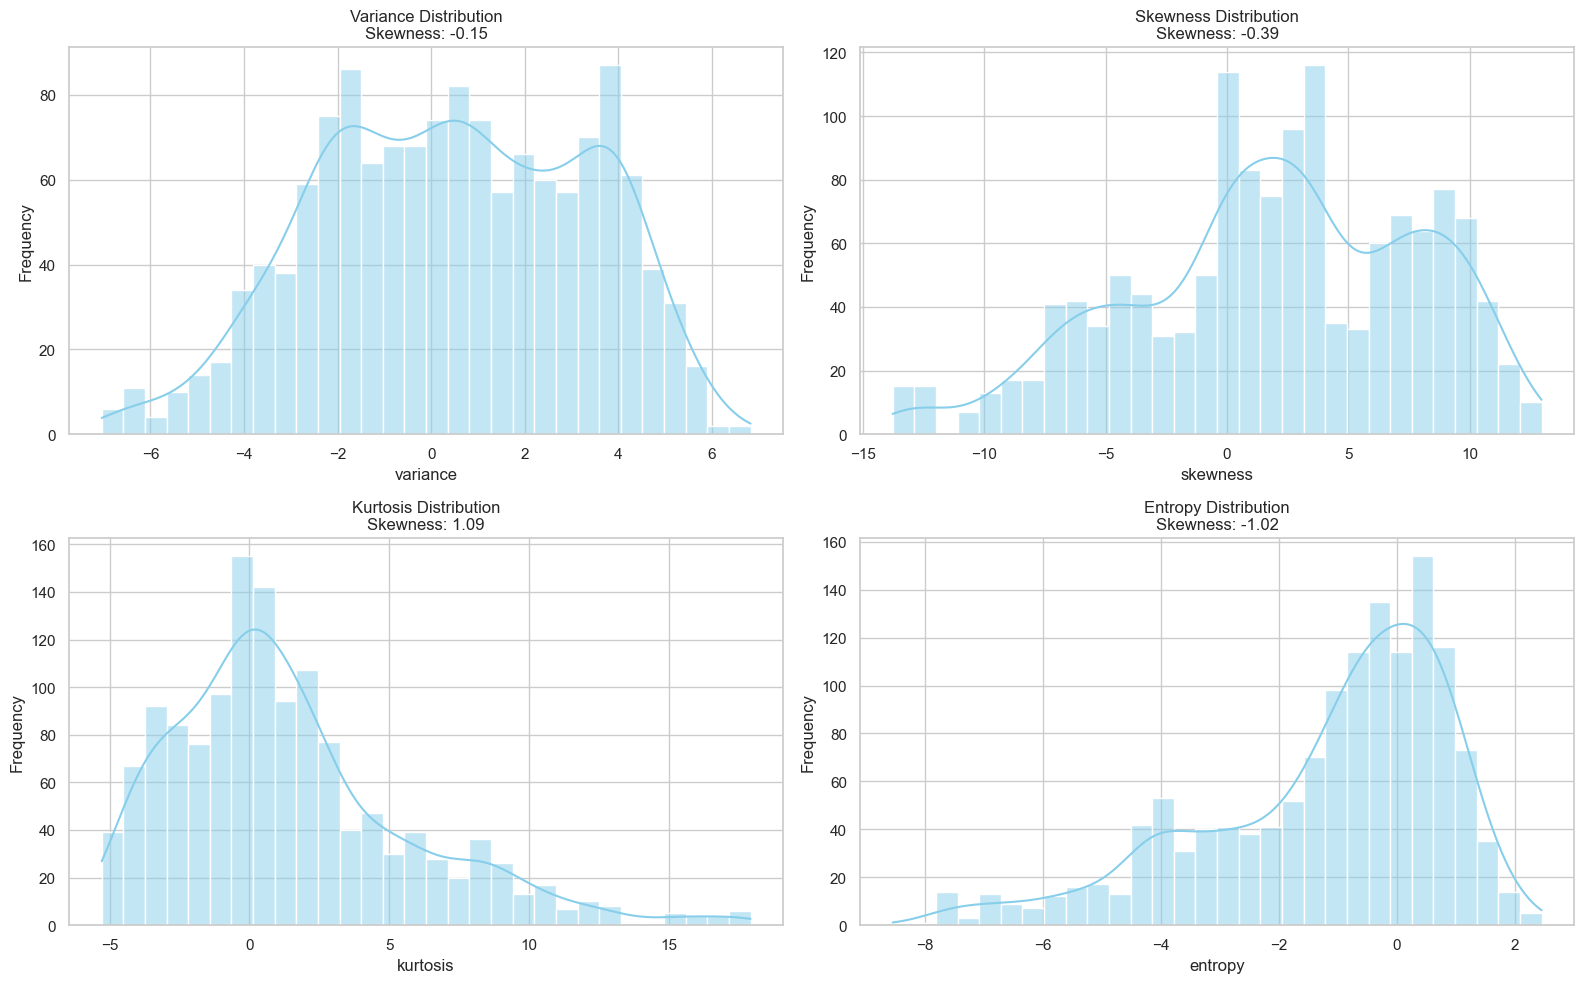

In [103]:
# Checking Continuous Features for Skewedness

sns.set(style='whitegrid')

# Plot distributions and display skewness values
features = ['variance', 'skewness', 'kurtosis', 'entropy']
plt.figure(figsize=(16, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data[feature], kde=True, color='skyblue', bins=30)
    skew_val = data[feature].skew()
    plt.title(f'{feature.capitalize()} Distribution\nSkewness: {skew_val:.2f}')
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

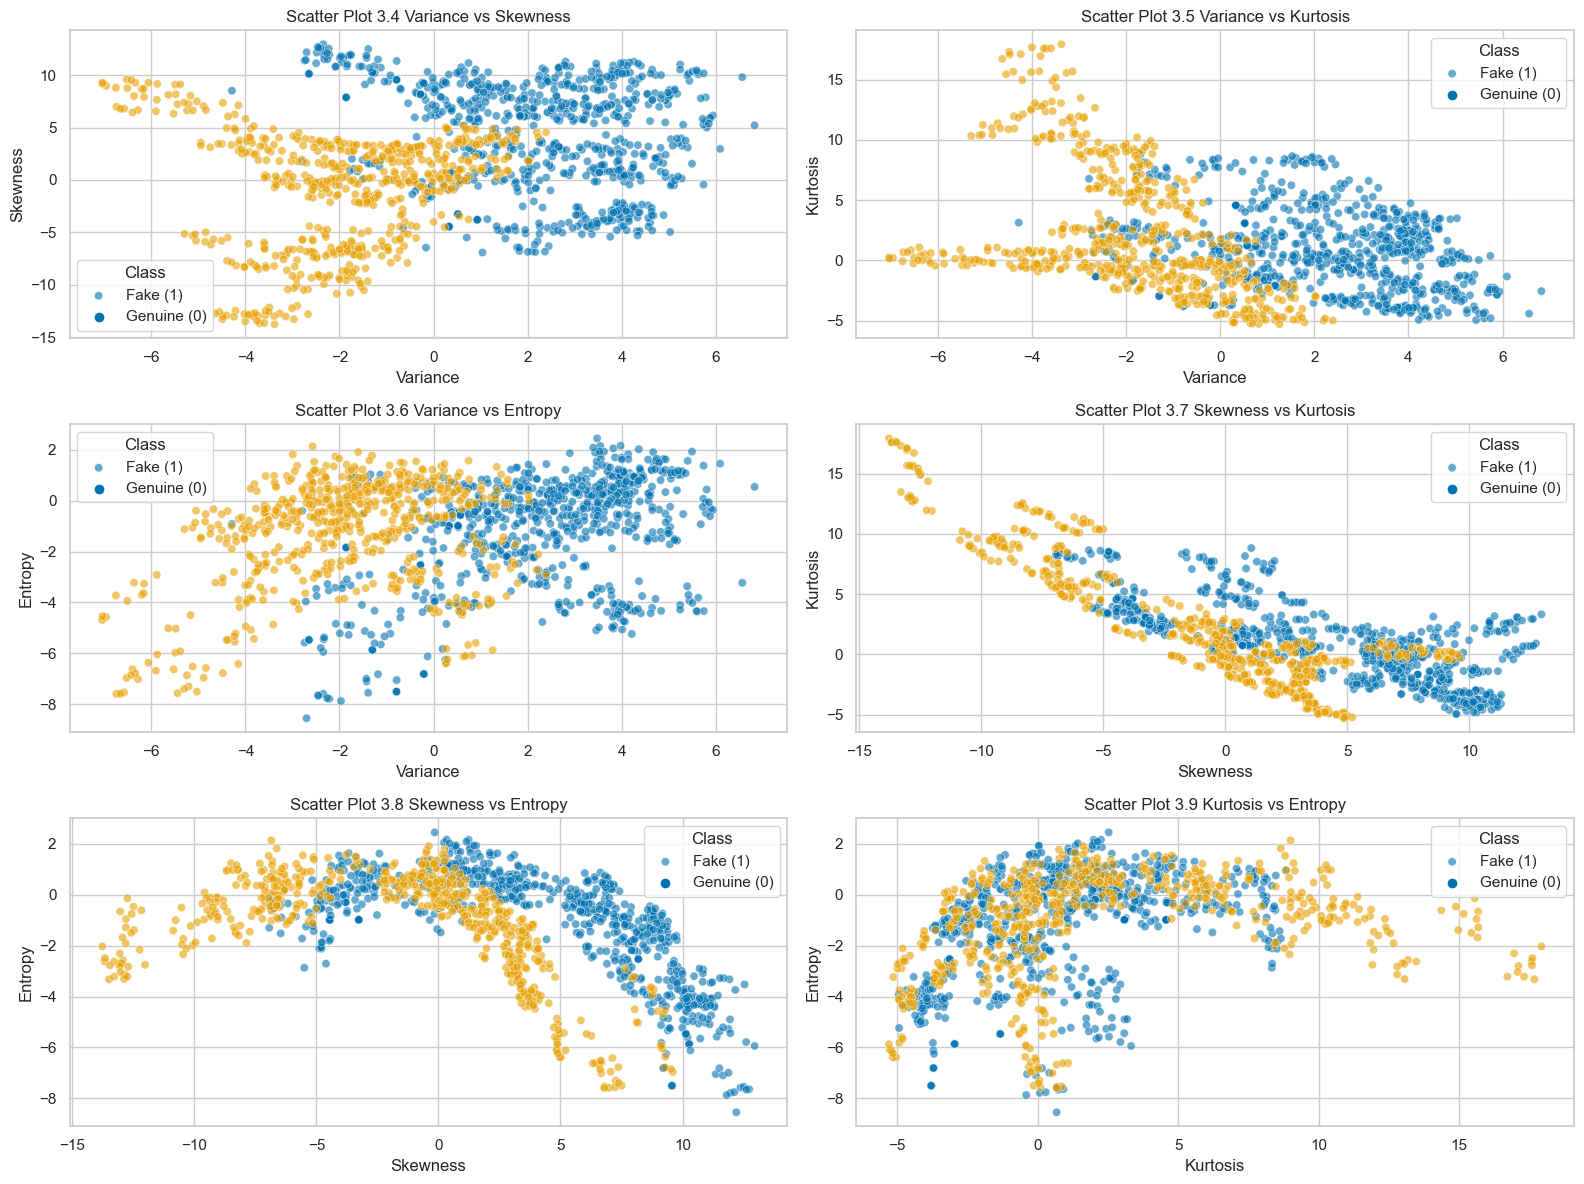

In [104]:

# Define feature pairs for scatter plots
feature_pairs = list(combinations(['variance', 'skewness', 'kurtosis', 'entropy'], 2))

# Plot scatter plots for each pair of features
plt.figure(figsize=(16, 12))
section_titles = [
    "3.4 Variance vs Skewness",
    "3.5 Variance vs Kurtosis",
    "3.6 Variance vs Entropy",
    "3.7 Skewness vs Kurtosis",
    "3.8 Skewness vs Entropy",
    "3.9 Kurtosis vs Entropy"
]

for i, ((feature_x, feature_y), title) in enumerate(zip(feature_pairs, section_titles), 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(
        data=data, 
        x=feature_x, 
        y=feature_y, 
        hue='class', 
        palette={0: "#0072B2", 1: "#E69F00"}, 
        alpha=0.6
    )
    plt.title(f'Scatter Plot {title}')
    plt.xlabel(feature_x.capitalize())
    plt.ylabel(feature_y.capitalize())
    plt.legend(title="Class", labels=["Fake (1)", "Genuine (0)"])

plt.tight_layout()
plt.show()


Preaparing Data 

In [105]:
    # Normalizing Numerical Features
    # Separate features and target
    X = data.drop(columns=['class'])  # Numerical features
    y = data['class']  # Target variable

    # Apply Min-Max Scaling
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Convert scaled data back into a DataFrame
    data_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    data_scaled['class'] = y  # Add target column back

    # Display first few rows of scaled data
    print(data_scaled.head())

   variance  skewness  kurtosis   entropy  class
0  0.769004  0.839643  0.106783  0.736628      0
1  0.835659  0.820982  0.121804  0.644326      0
2  0.786629  0.416648  0.310608  0.786951      0
3  0.757105  0.871699  0.054921  0.450440      0
4  0.531578  0.348662  0.424662  0.687362      0


In [106]:
# Shuffle and Split Data
# Split features and target variable
X = data_scaled.drop(columns=['class'])  # Features
y = data_scaled['class']  # Target variable (0: Fake, 1: Genuine)

# Split data into training and testing sets (40% test, 60% train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=5)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 823 samples.
Testing set has 549 samples.


We have chosen the following supervised learning models to build the trained models:

Support Vector Machines (SVM)
Gradient Boosting
K-Nearest Neighbors (KNeighbors) and 
Logistic Regression 


In [107]:
import time
from sklearn.metrics import fbeta_score, accuracy_score, confusion_matrix

# Function to train and evaluate a model
def train_predict(learner, X_train, y_train, X_test, y_test): 
    """
    Trains and evaluates a machine learning model.

    Parameters:
       - learner: The learning algorithm (SVM, etc.)
       - X_train: Training features
       - y_train: Training labels
       - X_test: Testing features
       - y_test: Testing labels

    Returns:
       - results: Dictionary containing accuracy (%), F2-score, prediction time, and confusion matrix.
    """

    results = {}
    beta = 2  # F2 score: favors recall

    # Train the model on the full training set
    start = time.time()
    learner.fit(X_train, y_train)
    end = time.time()
    results['train_time'] = end - start

    # Make predictions
    start = time.time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time.time()
    results['pred_time'] = end - start

    # Accuracy in percentage
    results['acc_train'] = accuracy_score(y_train, predictions_train) * 100
    results['acc_test'] = accuracy_score(y_test, predictions_test) * 100

    # F2 scores
    results['f_train'] = fbeta_score(y_train, predictions_train, beta=beta)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=beta)

    # Confusion matrix
    results['conf_mat'] = confusion_matrix(y_test, predictions_test)

    # Output summary
    print(f"{learner.__class__.__name__} trained on full dataset.")
    print(f"Training Accuracy: {results['acc_train']:.2f}%")
    print(f"Testing Accuracy: {results['acc_test']:.2f}%")
    print(f"Training F{beta} Score: {results['f_train']:.3f}")
    print(f"Testing F{beta} Score: {results['f_test']:.3f}")

    return results



In [108]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

KNN model 


KNeighborsClassifier trained on full dataset.
Training Accuracy: 99.88%
Testing Accuracy: 99.82%
Training F2 Score: 0.999
Testing F2 Score: 0.999


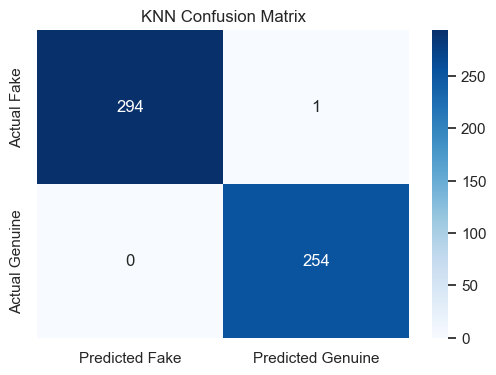


Cross-Validation Scores: [1.         1.         0.99635036 1.         0.99635036]
Mean CV Accuracy: 99.85% (±0.18%)

Best parameters found:  {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best cross-validation score: 99.88%
KNeighborsClassifier trained on full dataset.
Training Accuracy: 100.00%
Testing Accuracy: 99.82%
Training F2 Score: 1.000
Testing F2 Score: 0.999
Precision: 1.00
Recall: 1.00


In [110]:
from sklearn.metrics import precision_score, recall_score

# 1. Initialize KNN model (default k=5)
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  # p=2 means Euclidean distance

# 2. Train and evaluate using  existing function
knn_results = train_predict(knn_model, X_train, y_train, X_test, y_test)

# 3. Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(knn_results['conf_mat'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Fake', 'Predicted Genuine'],
            yticklabels=['Actual Fake', 'Actual Genuine'])
plt.title('KNN Confusion Matrix')
plt.show()

# 4. Cross-validation for robustness
cv_scores = cross_val_score(knn_model, X, y, cv=5, scoring='accuracy')
print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.2%} (±{cv_scores.std():.2%})")

# 5. Hyperparameter Tuning (Optimal k)
if True: 
    param_grid = {
        'n_neighbors': range(3, 21, 2),  # Test odd k values from 3 to 19
        'weights': ['uniform', 'distance'],  # Weight by distance
        'metric': ['euclidean', 'manhattan']  # Distance metrics
    }
    
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    print("\nBest parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}%".format(grid_search.best_score_*100))
    
    
    # Evaluate best model
    best_knn = grid_search.best_estimator_
    y_pred = best_knn.predict(X_test)
    best_results = train_predict(best_knn, X_train, y_train, X_test, y_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    

XGBoost and SVM model 

In [111]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [152]:
#Train and Evaluate the Models
# Initialize models
svm_model = SVC(kernel='rbf', C=10, random_state=5, probability=True)

xgb_model1 = XGBClassifier(n_estimators=100, learning_rate=0.1, eval_metric='logloss', random_state=5)

# choose the sample size (e.g., use full training set)
sample_size = X_train.shape[0]

# Train and evaluate SVM
print("\n--- SVM ---")
svm_results = train_predict(svm_model, X_train, y_train, X_test, y_test)


# Train and evaluate XGBoost
print("\n--- XGBoost ---")
xgb_results1 = train_predict(xgb_model1, X_train, y_train, X_test, y_test)



--- SVM ---
SVC trained on full dataset.
Training Accuracy: 100.00%
Testing Accuracy: 100.00%
Training F2 Score: 1.000
Testing F2 Score: 1.000

--- XGBoost ---
XGBClassifier trained on full dataset.
Training Accuracy: 100.00%
Testing Accuracy: 98.36%
Training F2 Score: 1.000
Testing F2 Score: 0.979


In [153]:
#Improved XGBoost Code with GridSearchCV

# Define the model
xgb = XGBClassifier(random_state=5, eval_metric='logloss')

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring='f1',  # Or 'f1_weighted' / 'f1_macro'
                           cv=3,
                           n_jobs=-1,
                           verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best estimator
best_xgb = grid_search.best_estimator_

# ====== Evaluate the best model ======
print("\n=== Evaluating Best XGBoost Model ===")
print(f"Best Parameters: {grid_search.best_params_}\n")

# Use train_predict function to evaluate
xgb_results = train_predict(best_xgb, X_train, y_train, X_test, y_test)

# Print confusion matrix
print("\nConfusion Matrix (Test Set):")
print(xgb_results['conf_mat'])


Fitting 3 folds for each of 108 candidates, totalling 324 fits

=== Evaluating Best XGBoost Model ===
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

XGBClassifier trained on full dataset.
Training Accuracy: 100.00%
Testing Accuracy: 99.27%
Training F2 Score: 1.000
Testing F2 Score: 0.994

Confusion Matrix (Test Set):
[[292   3]
 [  1 253]]


Featue Importance



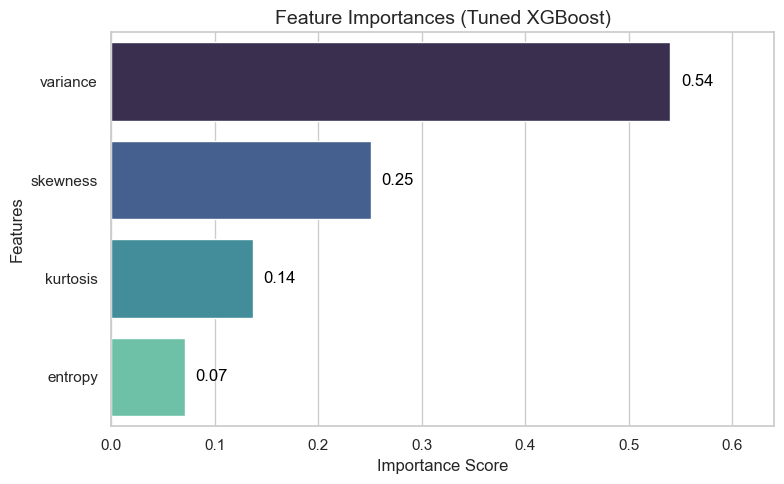

In [154]:

# Get feature importances from the best estimator
importances = best_xgb.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort feature importances
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_features = feature_names[indices]

# Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=sorted_importances, y=sorted_features, palette="mako")

# Add score labels to each bar
for i, v in enumerate(sorted_importances):
    ax.text(v + 0.01, i, f"{v:.2f}", color='black', va='center')
    
plt.xlim(0, max(sorted_importances) + 0.1)


plt.title('Feature Importances (Tuned XGBoost)', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()



Logistic Regression

In [115]:


# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Cost function (for reference/logging)
def compute_cost(X, y, weights):
    m = len(y)
    h = sigmoid(np.dot(X, weights))
    epsilon = 1e-5  # avoid log(0)
    cost = (-y * np.log(h + epsilon) - (1 - y) * np.log(1 - h + epsilon)).mean()
    return cost

# Logistic regression training function
def logistic_regression(X, y, lr=0.1, epochs=1000):
    X = np.insert(X.values, 0, 1, axis=1)  # Add bias term
    y = y.values.reshape(-1, 1)
    weights = np.zeros((X.shape[1], 1))

    for i in range(epochs):
        z = np.dot(X, weights)
        h = sigmoid(z)
        gradient = np.dot(X.T, (h - y)) / y.size
        weights -= lr * gradient

        if i % 100 == 0:
            cost = compute_cost(X, y, weights)
            print(f"Epoch {i} | Cost: {cost:.4f}")

    return weights

# Prediction function
def predict(X, weights):
    X = np.insert(X.values, 0, 1, axis=1)
    probs = sigmoid(np.dot(X, weights))
    return (probs >= 0.5).astype(int)

# Custom wrapper for training and evaluating
def train_predict_custom_logistic(X_train, y_train, X_test, y_test):
    print("Training custom Logistic Regression ")
    weights = logistic_regression(X_train, y_train, lr=0.1, epochs=1000)
    
    # Predict on train and test
    y_train_pred = predict(X_train, weights)
    y_test_pred = predict(X_test, weights)

    # Evaluation
    beta = 2
    results = {
        'acc_train': accuracy_score(y_train, y_train_pred) * 100,
        'acc_test': accuracy_score(y_test, y_test_pred) * 100,
        'f_train': fbeta_score(y_train, y_train_pred, beta=beta),
        'f_test': fbeta_score(y_test, y_test_pred, beta=beta),
        'conf_mat': confusion_matrix(y_test, y_test_pred)
    }

    # Output results
    print("Custom Logistic Regression Results:")
    print(f"Training Accuracy: {results['acc_train']:.2f}%")
    print(f"Testing Accuracy: {results['acc_test']:.2f}%")
    print(f"Training F{beta} Score: {results['f_train']:.3f}")
    print(f"Testing F{beta} Score: {results['f_test']:.3f}")
    print("Confusion Matrix:\n", results['conf_mat'])

    return results

#  Run the custom model
results_custom_logreg = train_predict_custom_logistic(X_train, y_train, X_test, y_test)


Training custom Logistic Regression 
Epoch 0 | Cost: 0.6905
Epoch 100 | Cost: 0.6213
Epoch 200 | Cost: 0.5811
Epoch 300 | Cost: 0.5490
Epoch 400 | Cost: 0.5226
Epoch 500 | Cost: 0.5004
Epoch 600 | Cost: 0.4814
Epoch 700 | Cost: 0.4648
Epoch 800 | Cost: 0.4501
Epoch 900 | Cost: 0.4370
Custom Logistic Regression Results:
Training Accuracy: 86.51%
Testing Accuracy: 84.34%
Training F2 Score: 0.769
Testing F2 Score: 0.759
Confusion Matrix:
 [[278  17]
 [ 69 185]]


In [128]:
from itertools import product
from sklearn.metrics import precision_score, recall_score  # Added imports

# Define parameter grid
learning_rates = [0.01, 0.05, 0.1, 0.2 ,0.3]
epoch_counts = [500, 1000, 2000, 3000, 4000,5000,6000]

# Store results
tuning_results = []

# Grid search
for lr, epochs in product(learning_rates, epoch_counts):
    print(f"\nTraining with learning rate: {lr}, epochs: {epochs}")

    # Train and evaluate
    X_train_df = pd.DataFrame(X_train)
    X_test_df = pd.DataFrame(X_test)
    weights = logistic_regression(X_train_df, y_train, lr=lr, epochs=epochs)
    y_train_pred = predict(X_train_df, weights)
    y_test_pred = predict(X_test_df, weights)

    beta = 2
    # Calculate metrics
    acc_train = accuracy_score(y_train, y_train_pred) * 100
    acc_test = accuracy_score(y_test, y_test_pred) * 100
    f_train = fbeta_score(y_train, y_train_pred, beta=beta)
    f_test = fbeta_score(y_test, y_test_pred, beta=beta)
    precision_train = precision_score(y_train, y_train_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_train = recall_score(y_train, y_train_pred)
    recall_test = recall_score(y_test, y_test_pred)
    conf = confusion_matrix(y_test, y_test_pred)

    tuning_results.append({
        'lr': lr,
        'epochs': epochs,
        'acc_train': acc_train,
        'acc_test': acc_test,
        'f_train': f_train,
        'f_test': f_test,
        'precision_train': precision_train,
        'precision_test': precision_test,
        'recall_train': recall_train,
        'recall_test': recall_test,
        'conf_mat': conf
    })

# Results DataFrame
results_df = pd.DataFrame(tuning_results)

# Print all metrics sorted by F2 score
print("\nAll tuning results sorted by testing F2 score:")
print(results_df.sort_values(by='f_test', ascending=False)[[
    'lr', 'epochs', 'acc_test', 'f_test', 'precision_test', 'recall_test'
]].round(3))


# === Get the best weights from tuning ===
best_lr = 0.3  # Replace with  best learning rate from results_df
best_epochs = 6000  # Replace with  best epoch count from results_df

# Retrain with best parameters to get weights (or extract from tuning_results)
X_train_df = pd.DataFrame(X_train)
custom_best_weights = logistic_regression(X_train_df, y_train, lr=best_lr, epochs=best_epochs)

# can use `custom_best_weights` in PCA visualization code
# === Show detailed result for best parameters ===
target_result = results_df[(results_df['lr'] == 0.3) & (results_df['epochs'] == 6000)].iloc[0]
print("\nCustom Logistic Regression Results for lr=0.3, epochs=6000:")
print(f"Training Accuracy: {target_result['acc_train']:.2f}%")
print(f"Testing Accuracy: {target_result['acc_test']:.2f}%")
print(f"Training F{beta} Score: {target_result['f_train']:.3f}")
print(f"Testing F{beta} Score: {target_result['f_test']:.3f}")
print(f"Training Precision: {target_result['precision_train']:.3f}")
print(f"Testing Precision: {target_result['precision_test']:.3f}")
print(f"Training Recall: {target_result['recall_train']:.3f}")
print(f"Testing Recall: {target_result['recall_test']:.3f}")
print("Confusion Matrix:\n", target_result['conf_mat'])







Training with learning rate: 0.01, epochs: 500
Epoch 0 | Cost: 0.6929
Epoch 100 | Cost: 0.6742
Epoch 200 | Cost: 0.6643
Epoch 300 | Cost: 0.6573
Epoch 400 | Cost: 0.6514

Training with learning rate: 0.01, epochs: 1000
Epoch 0 | Cost: 0.6929
Epoch 100 | Cost: 0.6742
Epoch 200 | Cost: 0.6643
Epoch 300 | Cost: 0.6573
Epoch 400 | Cost: 0.6514
Epoch 500 | Cost: 0.6460
Epoch 600 | Cost: 0.6409
Epoch 700 | Cost: 0.6359
Epoch 800 | Cost: 0.6310
Epoch 900 | Cost: 0.6263

Training with learning rate: 0.01, epochs: 2000
Epoch 0 | Cost: 0.6929
Epoch 100 | Cost: 0.6742
Epoch 200 | Cost: 0.6643
Epoch 300 | Cost: 0.6573
Epoch 400 | Cost: 0.6514
Epoch 500 | Cost: 0.6460
Epoch 600 | Cost: 0.6409
Epoch 700 | Cost: 0.6359
Epoch 800 | Cost: 0.6310
Epoch 900 | Cost: 0.6263
Epoch 1000 | Cost: 0.6217
Epoch 1100 | Cost: 0.6172
Epoch 1200 | Cost: 0.6129
Epoch 1300 | Cost: 0.6086
Epoch 1400 | Cost: 0.6044
Epoch 1500 | Cost: 0.6004
Epoch 1600 | Cost: 0.5964
Epoch 1700 | Cost: 0.5925
Epoch 1800 | Cost: 0.5888
E

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training with learning rate: 0.01, epochs: 4000
Epoch 0 | Cost: 0.6929
Epoch 100 | Cost: 0.6742
Epoch 200 | Cost: 0.6643
Epoch 300 | Cost: 0.6573
Epoch 400 | Cost: 0.6514
Epoch 500 | Cost: 0.6460
Epoch 600 | Cost: 0.6409
Epoch 700 | Cost: 0.6359
Epoch 800 | Cost: 0.6310
Epoch 900 | Cost: 0.6263
Epoch 1000 | Cost: 0.6217
Epoch 1100 | Cost: 0.6172
Epoch 1200 | Cost: 0.6129
Epoch 1300 | Cost: 0.6086
Epoch 1400 | Cost: 0.6044
Epoch 1500 | Cost: 0.6004
Epoch 1600 | Cost: 0.5964
Epoch 1700 | Cost: 0.5925
Epoch 1800 | Cost: 0.5888
Epoch 1900 | Cost: 0.5851
Epoch 2000 | Cost: 0.5814
Epoch 2100 | Cost: 0.5779
Epoch 2200 | Cost: 0.5744
Epoch 2300 | Cost: 0.5711
Epoch 2400 | Cost: 0.5678
Epoch 2500 | Cost: 0.5645
Epoch 2600 | Cost: 0.5613
Epoch 2700 | Cost: 0.5582
Epoch 2800 | Cost: 0.5552
Epoch 2900 | Cost: 0.5522
Epoch 3000 | Cost: 0.5493
Epoch 3100 | Cost: 0.5464
Epoch 3200 | Cost: 0.5436
Epoch 3300 | Cost: 0.5408
Epoch 3400 | Cost: 0.5381
Epoch 3500 | Cost: 0.5355
Epoch 3600 | Cost: 0.5329
E

Epoch 3400 | Cost: 0.3645
Epoch 3500 | Cost: 0.3612
Epoch 3600 | Cost: 0.3579
Epoch 3700 | Cost: 0.3548
Epoch 3800 | Cost: 0.3517
Epoch 3900 | Cost: 0.3487
Epoch 4000 | Cost: 0.3458
Epoch 4100 | Cost: 0.3430
Epoch 4200 | Cost: 0.3402
Epoch 4300 | Cost: 0.3375
Epoch 4400 | Cost: 0.3349
Epoch 4500 | Cost: 0.3323
Epoch 4600 | Cost: 0.3298
Epoch 4700 | Cost: 0.3273
Epoch 4800 | Cost: 0.3249
Epoch 4900 | Cost: 0.3226
Epoch 5000 | Cost: 0.3203
Epoch 5100 | Cost: 0.3180
Epoch 5200 | Cost: 0.3158
Epoch 5300 | Cost: 0.3136
Epoch 5400 | Cost: 0.3115
Epoch 5500 | Cost: 0.3094
Epoch 5600 | Cost: 0.3073
Epoch 5700 | Cost: 0.3053
Epoch 5800 | Cost: 0.3033
Epoch 5900 | Cost: 0.3014

Training with learning rate: 0.1, epochs: 500
Epoch 0 | Cost: 0.6905
Epoch 100 | Cost: 0.6213
Epoch 200 | Cost: 0.5811
Epoch 300 | Cost: 0.5490
Epoch 400 | Cost: 0.5226

Training with learning rate: 0.1, epochs: 1000
Epoch 0 | Cost: 0.6905
Epoch 100 | Cost: 0.6213
Epoch 200 | Cost: 0.5811
Epoch 300 | Cost: 0.5490
Epoch 40


Training with learning rate: 0.2, epochs: 4000
Epoch 0 | Cost: 0.6879
Epoch 100 | Cost: 0.5807
Epoch 200 | Cost: 0.5223
Epoch 300 | Cost: 0.4812
Epoch 400 | Cost: 0.4499
Epoch 500 | Cost: 0.4250
Epoch 600 | Cost: 0.4042
Epoch 700 | Cost: 0.3866
Epoch 800 | Cost: 0.3713
Epoch 900 | Cost: 0.3578
Epoch 1000 | Cost: 0.3457
Epoch 1100 | Cost: 0.3348
Epoch 1200 | Cost: 0.3248
Epoch 1300 | Cost: 0.3157
Epoch 1400 | Cost: 0.3072
Epoch 1500 | Cost: 0.2994
Epoch 1600 | Cost: 0.2920
Epoch 1700 | Cost: 0.2852
Epoch 1800 | Cost: 0.2787
Epoch 1900 | Cost: 0.2726
Epoch 2000 | Cost: 0.2669
Epoch 2100 | Cost: 0.2614
Epoch 2200 | Cost: 0.2562
Epoch 2300 | Cost: 0.2513
Epoch 2400 | Cost: 0.2466
Epoch 2500 | Cost: 0.2421
Epoch 2600 | Cost: 0.2378
Epoch 2700 | Cost: 0.2337
Epoch 2800 | Cost: 0.2298
Epoch 2900 | Cost: 0.2260
Epoch 3000 | Cost: 0.2224
Epoch 3100 | Cost: 0.2190
Epoch 3200 | Cost: 0.2156
Epoch 3300 | Cost: 0.2124
Epoch 3400 | Cost: 0.2093
Epoch 3500 | Cost: 0.2063
Epoch 3600 | Cost: 0.2034
Ep

Epoch 2300 | Cost: 0.2078
Epoch 2400 | Cost: 0.2034
Epoch 2500 | Cost: 0.1992
Epoch 2600 | Cost: 0.1953
Epoch 2700 | Cost: 0.1915
Epoch 2800 | Cost: 0.1880
Epoch 2900 | Cost: 0.1846
Epoch 3000 | Cost: 0.1813
Epoch 3100 | Cost: 0.1782
Epoch 3200 | Cost: 0.1752
Epoch 3300 | Cost: 0.1724
Epoch 3400 | Cost: 0.1696
Epoch 3500 | Cost: 0.1670
Epoch 3600 | Cost: 0.1645
Epoch 3700 | Cost: 0.1620
Epoch 3800 | Cost: 0.1597
Epoch 3900 | Cost: 0.1574
Epoch 4000 | Cost: 0.1553
Epoch 4100 | Cost: 0.1532
Epoch 4200 | Cost: 0.1511
Epoch 4300 | Cost: 0.1492
Epoch 4400 | Cost: 0.1473
Epoch 4500 | Cost: 0.1455
Epoch 4600 | Cost: 0.1437
Epoch 4700 | Cost: 0.1420
Epoch 4800 | Cost: 0.1404
Epoch 4900 | Cost: 0.1388
Epoch 5000 | Cost: 0.1372
Epoch 5100 | Cost: 0.1357
Epoch 5200 | Cost: 0.1342
Epoch 5300 | Cost: 0.1328
Epoch 5400 | Cost: 0.1314
Epoch 5500 | Cost: 0.1301
Epoch 5600 | Cost: 0.1288
Epoch 5700 | Cost: 0.1275
Epoch 5800 | Cost: 0.1263
Epoch 5900 | Cost: 0.1251

All tuning results sorted by testing 

In [117]:

sorted_results = results_df.sort_values(by='f_test', ascending=False)[['lr', 'epochs', 'acc_test', 'f_test']].reset_index(drop=True)
display(sorted_results.style
    .format({'acc_test': '{:.2f}%', 'f_test': '{:.3f}'})
    .background_gradient(subset=['f_test'], cmap='Blues')
    .set_caption("All Tuning Results Sorted by Testing F2 Score"))
sorted_results.to_excel('tuning_results_sorted.xlsx', index=False)
print("Saved to 'tuning_results_sorted.xlsx'")

,lr,epochs,acc_test,f_test
0,0.300000,6000,95.99%,0.954
1,0.300000,5000,95.63%,0.948
2,0.300000,4000,95.63%,0.943
3,0.200000,6000,95.63%,0.943
4,0.200000,5000,95.08%,0.938
5,0.300000,3000,94.54%,0.931
6,0.200000,4000,94.54%,0.931
7,0.300000,2000,93.08%,0.908
8,0.200000,3000,93.08%,0.908
9,0.100000,6000,93.08%,0.908


Saved to 'tuning_results_sorted.xlsx'


Feature imporatance 

In [129]:
weights = logistic_regression(X_train, y_train)
print(f"Weights shape: {weights.shape}")
print(f"Number of features: {X_train.shape[1]}")

Epoch 0 | Cost: 0.6905
Epoch 100 | Cost: 0.6213
Epoch 200 | Cost: 0.5811
Epoch 300 | Cost: 0.5490
Epoch 400 | Cost: 0.5226
Epoch 500 | Cost: 0.5004
Epoch 600 | Cost: 0.4814
Epoch 700 | Cost: 0.4648
Epoch 800 | Cost: 0.4501
Epoch 900 | Cost: 0.4370
Weights shape: (5, 1)
Number of features: 4


Epoch 0 | Cost: 0.6905
Epoch 100 | Cost: 0.6213
Epoch 200 | Cost: 0.5811
Epoch 300 | Cost: 0.5490
Epoch 400 | Cost: 0.5226
Epoch 500 | Cost: 0.5004
Epoch 600 | Cost: 0.4814
Epoch 700 | Cost: 0.4648
Epoch 800 | Cost: 0.4501
Epoch 900 | Cost: 0.4370


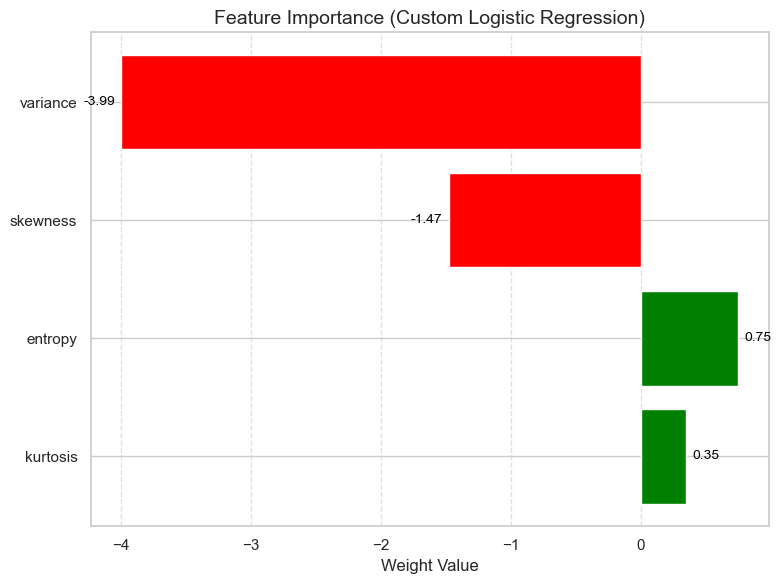

In [130]:


def plot_logistic_feature_importance(weights, feature_names):
    weights = weights.flatten()

    # Remove bias
    weights_no_bias = weights[1:]

    # Create series
    feature_importance = pd.Series(weights_no_bias, index=feature_names)

    # Sort by absolute value
    feature_importance = feature_importance.reindex(
        feature_importance.abs().sort_values(ascending=False).index
    )

    # Colors by sign
    colors = feature_importance.apply(lambda x: 'green' if x > 0 else 'red')

    # Plot
    plt.figure(figsize=(8, 6))
    bars = plt.barh(feature_importance.index, feature_importance.values, color=colors)

    # Add value labels to bars
    for bar in bars:
        width = bar.get_width()
        plt.text(
            width + 0.05 * np.sign(width),  # Position right or left depending on sign
            bar.get_y() + bar.get_height() / 2,
            f'{width:.2f}',
            va='center',
            ha='left' if width > 0 else 'right',
            fontsize=10,
            color='black'
        )

    plt.title('Feature Importance (Custom Logistic Regression)', fontsize=14)
    plt.xlabel('Weight Value', fontsize=12)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
# --- Example usage ---
# After training
weights = logistic_regression(X_train, y_train) 
plot_logistic_feature_importance(weights, X_train.columns)


In [147]:
from sklearn.metrics import precision_score, recall_score

# Get predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)
y_pred_custom = predict(X_test, custom_weights).flatten()

# Calculate metrics
model_metrics = [
    {
        "Model": "XGBoost",
        "Precision": precision_score(y_test, y_pred_xgb),
        "Recall": recall_score(y_test, y_pred_xgb)
    },
    {
        "Model": "SVM",
        "Precision": precision_score(y_test, y_pred_svm),
        "Recall": recall_score(y_test, y_pred_svm)
    },
    {
        "Model": "KNN",
        "Precision": precision_score(y_test, y_pred_knn),
        "Recall": recall_score(y_test, y_pred_knn)
    },
    
    
]

# Convert to DataFrame
import pandas as pd
df_metrics = pd.DataFrame(model_metrics)

# Display
print(df_metrics.round(3))


     Model  Precision  Recall
0  XGBoost      0.988   0.976
1      SVM      1.000   1.000
2      KNN      0.996   1.000


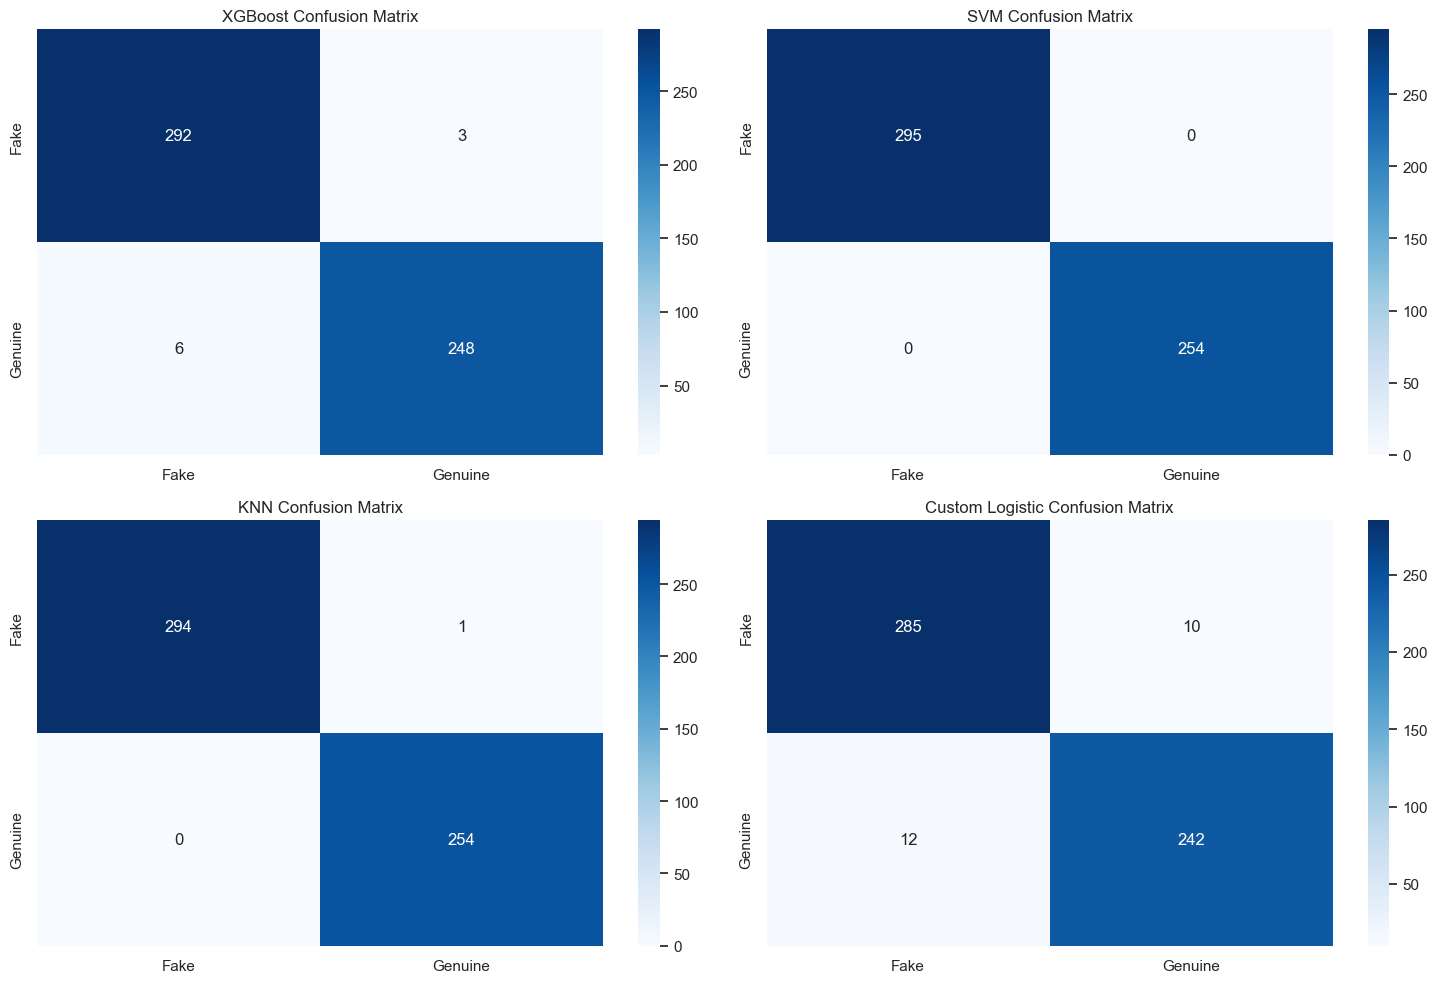

In [155]:
# Add the confusion matrix for the tuned logistic model explicitly
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 grid for 4 models
models = {
    "XGBoost": xgb_model, 
    "SVM": svm_model,
    "KNN": knn_model,
    "Custom Logistic": target_result['conf_mat']  # Use the best result from tuning
}

# Flatten axes for easy iteration
axes = axes.flatten()

for ax, (name, model) in zip(axes, models.items()):
    if name == "Custom Logistic":
        cm = model  # Already the matrix
    else:
        preds = model.predict(X_test)
        cm = confusion_matrix(y_test, preds)
    
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues',
                xticklabels=['Fake', 'Genuine'],
                yticklabels=['Fake', 'Genuine'])
    ax.set_title(f'{name} Confusion Matrix')

plt.tight_layout()
plt.show()


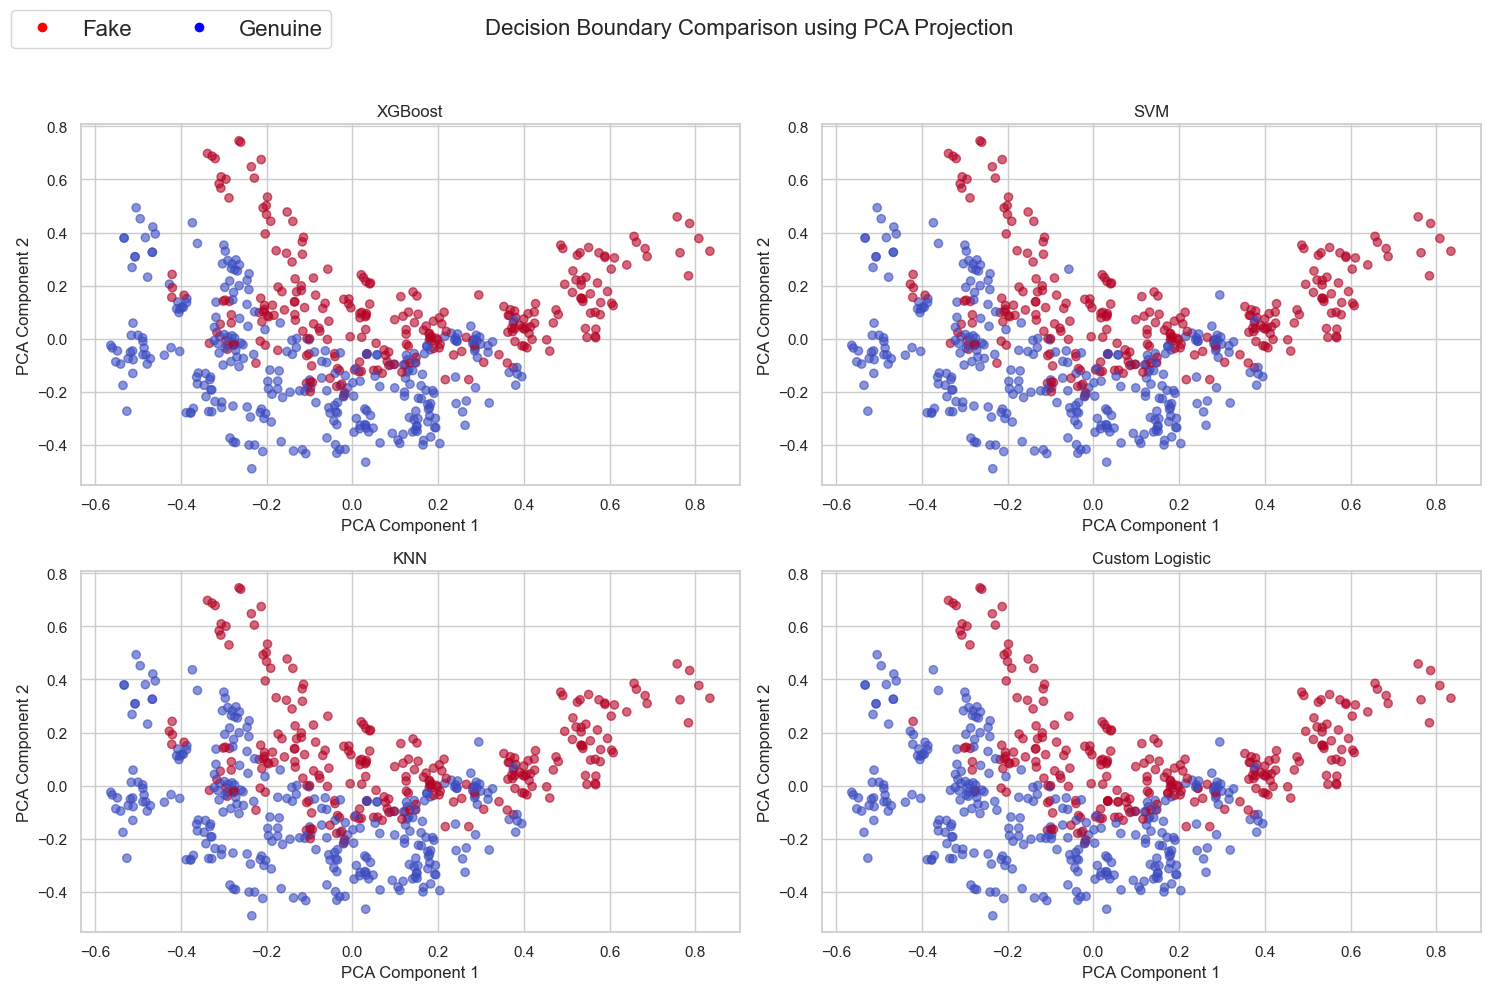

In [133]:
from sklearn.decomposition import PCA


# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)

# Predict using all models
models = {
    "XGBoost": best_xgb,
    "SVM": svm_model,
    "KNN": best_knn,
    "Custom Logistic": None
}

predictions = {}

for name, model in models.items():
    if name == "Custom Logistic":
        preds = predict(pd.DataFrame(X_test), custom_best_weights).flatten()
    else:
        preds = model.predict(X_test)
    predictions[name] = preds

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for ax, (model_name, preds) in zip(axes, predictions.items()):
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=preds, cmap='coolwarm', alpha=0.6)
    ax.set_title(model_name)
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')

# Common legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Fake', markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Genuine', markerfacecolor='blue', markersize=8)
]
fig.legend(handles=legend_elements, loc='upper left', ncol=4, fontsize=16)

fig.suptitle('Decision Boundary Comparison using PCA Projection', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


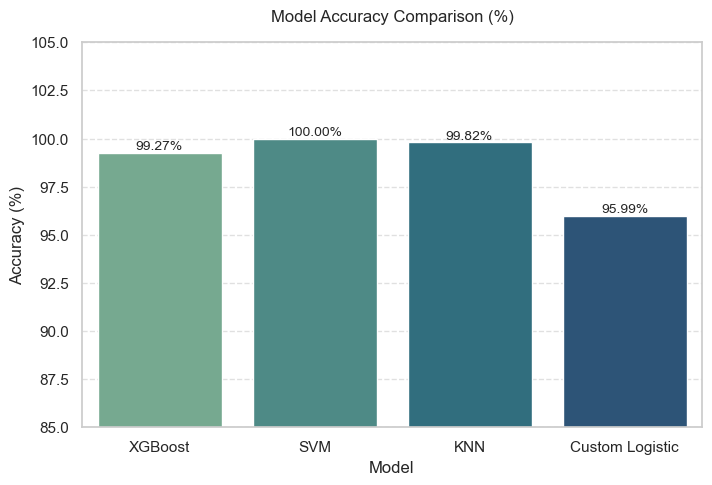

In [149]:
# Convert to percentages and round
accuracy_xgb = round(xgb_results['acc_test'], 2)
accuracy_svm = round(svm_results['acc_test'], 2)
accuracy_knn = round(knn_results['acc_test'], 2)
custom_accuracy = round(target_result['acc_test'], 2)

# 1. Create accuracy results in percentage
results = [
    {"Model": "XGBoost", "Accuracy": accuracy_xgb},
    {"Model": "SVM", "Accuracy": accuracy_svm},
    {"Model": "KNN", "Accuracy": accuracy_knn},
    {"Model": "Custom Logistic", "Accuracy": custom_accuracy}
]

results_df = pd.DataFrame(results)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Model', y='Accuracy', palette='crest')

# Annotate percentage labels on top of bars
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f"{height:.2f}%", 
                       (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='bottom', fontsize=10)

plt.ylim(85, 105)
plt.title("Model Accuracy Comparison (%)", pad=15)
plt.ylabel("Accuracy (%)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


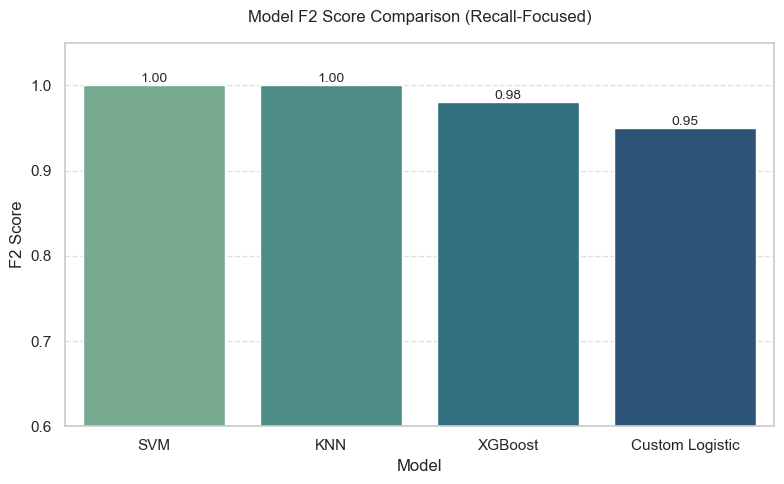

In [143]:

# 1. Define model predictions (F2 Score with beta=2)
f2_xgb = fbeta_score(y_test, xgb_model.predict(X_test), beta=2)
f2_svm = fbeta_score(y_test, svm_model.predict(X_test), beta=2)
f2_knn = fbeta_score(y_test, knn_model.predict(X_test), beta=2)
f2_custom = target_result['f_test']  # Already stored during tuning

# 2. Prepare results (rounded for display)
f2_results = [
    {"Model": "XGBoost", "F2 Score": round(f2_xgb, 2)},
    {"Model": "SVM", "F2 Score": round(f2_svm, 2)},
    {"Model": "KNN", "F2 Score": round(f2_knn, 2)},
    {"Model": "Custom Logistic", "F2 Score": round(f2_custom, 2)}
]

f2_df = pd.DataFrame(f2_results).sort_values('F2 Score', ascending=False)

# 3. Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=f2_df, x='Model', y='F2 Score', palette='crest')

# Annotate bar heights
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.ylim(0.6, 1.05)  # For F2 score range between 0 and 1
plt.title("Model F2 Score Comparison (Recall-Focused)", pad=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.ylabel("F2 Score")
plt.tight_layout()
plt.show()


Predict 5 Random Samples with All Models

In [125]:
def compare_model_predictions(X_test, y_test, models_dict, label_map={0: "Fake", 1: "Genuine"}, 
                               sample_size=5, random_seed=42, custom_log_weights=None):
    """
    Compare predictions of multiple models on random samples from the test set.
    """

    # Set random seed and select random samples
    np.random.seed(random_seed)
    test_indices = np.random.choice(len(X_test), size=min(sample_size, len(X_test)), replace=False)
    X_sample = X_test.iloc[test_indices]
    y_sample = y_test.iloc[test_indices]

    # Create comparison DataFrame
    results = pd.DataFrame({
        'Actual': y_sample.map(label_map),
        'Actual_Value': y_sample
    })

    # Get predictions from each model
    for model_name, model in models_dict.items():
        if model_name == "CustomLogistic":
            if custom_log_weights is None:
                raise ValueError("Custom logistic regression weights must be provided.")
            preds = predict(X_sample, custom_log_weights).flatten()
            results[f'{model_name}_Pred'] = preds
        else:
            if hasattr(model, 'predict_proba'):
                proba = model.predict_proba(X_sample)[:, 1]
                results[f'{model_name}_Proba'] = [f"{p:.2%}" for p in proba]
            preds = model.predict(X_sample)
            results[f'{model_name}_Pred'] = preds
        
        # Map predictions and check correctness
        results[f'{model_name}_Pred_Label'] = results[f'{model_name}_Pred'].map(label_map)
        results[f'{model_name}_Correct'] = results[f'{model_name}_Pred'] == results['Actual_Value']

    # Columns to display
    display_cols = ['Actual']
    proba_cols = []
    for model_name in models_dict:
        display_cols.extend([f'{model_name}_Pred_Label', f'{model_name}_Correct'])
        if f'{model_name}_Proba' in results.columns:
            proba_cols.append(f'{model_name}_Proba')

    # Final DataFrame for display
    display_df = results[display_cols + proba_cols]
    display_df.columns = [col.replace('_', ' ').replace('Pred Label', 'Prediction') for col in display_df.columns]

    def highlight_correct(val):
        if isinstance(val, bool):
            return 'background-color: lightgreen' if val else 'background-color: mistyrose'
        return ''

    return display_df.style.applymap(highlight_correct, subset=[col for col in display_df.columns if 'Correct' in col])
# Example usage:
models = {
    "XGBoost": xgb_model, 
    "KNN": knn_model,      
    "SVM": svm_model,      
    "CustomLogistic": "custom"  # Placeholder - use weights
}

# Get weights from custom logistic training
custom_weights = logistic_regression(X_train, y_train, lr=0.3, epochs=6000)

# Run comparison
prediction_comparison = compare_model_predictions(
    X_test, y_test, 
    models,
    custom_log_weights=custom_weights
)
display(prediction_comparison)

Epoch 0 | Cost: 0.6855
Epoch 100 | Cost: 0.5483
Epoch 200 | Cost: 0.4810
Epoch 300 | Cost: 0.4366
Epoch 400 | Cost: 0.4041
Epoch 500 | Cost: 0.3786
Epoch 600 | Cost: 0.3577
Epoch 700 | Cost: 0.3400
Epoch 800 | Cost: 0.3248
Epoch 900 | Cost: 0.3113
Epoch 1000 | Cost: 0.2993
Epoch 1100 | Cost: 0.2885
Epoch 1200 | Cost: 0.2787
Epoch 1300 | Cost: 0.2697
Epoch 1400 | Cost: 0.2614
Epoch 1500 | Cost: 0.2537
Epoch 1600 | Cost: 0.2466
Epoch 1700 | Cost: 0.2399
Epoch 1800 | Cost: 0.2337
Epoch 1900 | Cost: 0.2279
Epoch 2000 | Cost: 0.2224
Epoch 2100 | Cost: 0.2172
Epoch 2200 | Cost: 0.2124
Epoch 2300 | Cost: 0.2078
Epoch 2400 | Cost: 0.2034
Epoch 2500 | Cost: 0.1992
Epoch 2600 | Cost: 0.1953
Epoch 2700 | Cost: 0.1915
Epoch 2800 | Cost: 0.1880
Epoch 2900 | Cost: 0.1846
Epoch 3000 | Cost: 0.1813
Epoch 3100 | Cost: 0.1782
Epoch 3200 | Cost: 0.1752
Epoch 3300 | Cost: 0.1724
Epoch 3400 | Cost: 0.1696
Epoch 3500 | Cost: 0.1670
Epoch 3600 | Cost: 0.1645
Epoch 3700 | Cost: 0.1620
Epoch 3800 | Cost: 0.159

,Actual,XGBoost Prediction,XGBoost Correct,KNN Prediction,KNN Correct,SVM Prediction,SVM Correct,CustomLogistic Prediction,CustomLogistic Correct,XGBoost Proba,KNN Proba,SVM Proba
338,Fake,Fake,True,Fake,True,Fake,True,Fake,True,0.14%,0.00%,0.00%
904,Genuine,Genuine,True,Genuine,True,Genuine,True,Genuine,True,98.67%,100.00%,99.65%
755,Fake,Fake,True,Fake,True,Fake,True,Fake,True,0.56%,0.00%,0.28%
1014,Genuine,Genuine,True,Genuine,True,Genuine,True,Genuine,True,97.50%,100.00%,97.52%
8,Fake,Fake,True,Fake,True,Fake,True,Fake,True,0.08%,0.00%,0.00%


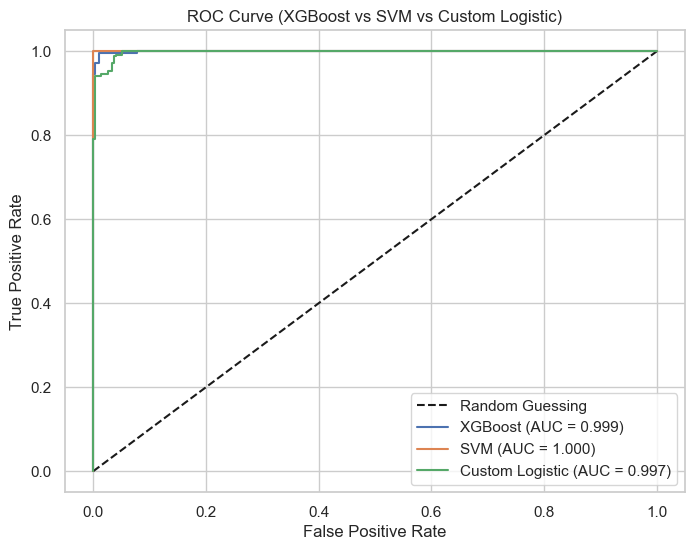

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Initialize plot
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

# Models to compare
models = {
    "XGBoost": xgb_model,        
    "SVM": svm_model,            
    "Custom Logistic": None       
}

# --- Get probabilities for each model ---
for name, model in models.items():
    if name == "Custom Logistic":
        # Manual probability calculation for custom logistic
        X_test_with_bias = np.insert(X_test.values, 0, 1, axis=1)  # Add bias term
        proba = sigmoid(np.dot(X_test_with_bias, custom_weights)).flatten()
    else:
        # Standard models (XGBoost, SVM)
        proba = model.predict_proba(X_test)[:, 1]  # P(class=1)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

# --- Format plot ---
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (XGBoost vs SVM vs Custom Logistic)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()